In [1]:
!pip install transformers tensorflow datasets kaggle


[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!if [ ! -e ~/.kaggle/kaggle.json ]; then mkdir -p ~/.kaggle; cp ~/kaggle.json ~/.kaggle; echo "done"; fi
!chmod 600 ~/.kaggle/kaggle.json
!ls -alR ~/.kaggle

/opt/app-root/src/.kaggle:
total 12
drwxr-sr-x.  2 1006090000 1006090000 4096 Oct  5 08:28 .
drwxrwsr-x. 14 root       1006090000 4096 Oct  5 08:34 ..
-rw-------.  1 1006090000 1006090000   69 Oct  5 08:28 kaggle.json


In [3]:
# https://nihcc.app.box.com/v/ChestXray-NIHCC

#kaggle datasets list
!mkdir -p models
!rm -rf chest_xray
!kaggle datasets download paultimothymooney/chest-xray-pneumonia
!if [ ! -d chest_xray.dataset ]; then unzip -q chest-xray-pneumonia.zip; mv chest_xray chest_xray.dataset; fi
!rm -rf chest_xray.dataset/__MACOSX
!echo "Download complete"

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Download complete


In [4]:
import tensorflow as tf
#from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

2024-10-05 08:49:51.372523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 08:49:51.372578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 08:49:51.374179: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 08:49:51.382595: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-05 08:49:52.539874: W tensorflow/comp

Number of replicas: 1
2.15.1


In [5]:
vgg_base = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(228,228,3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

print('VGG19 Loaded')
print(vgg_base.summary())

VGG19 Loaded
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 228, 228, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 228, 228, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 114, 114, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 114, 114, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 114, 114, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 57, 57, 128)

In [6]:
# Get model to output 3D feature maps (height, width, features)
altmodel = tf.keras.models.Sequential()

# Layer 1
altmodel.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=(228, 228, 3)))
altmodel.add(tf.keras.layers.Activation('relu'))
altmodel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 2
altmodel.add(tf.keras.layers.Conv2D(32, (3, 3)))
altmodel.add(tf.keras.layers.Activation('relu'))
altmodel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 3
altmodel.add(tf.keras.layers.Conv2D(64, (3, 3)))
altmodel.add(tf.keras.layers.Activation('relu'))
altmodel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Apply flattening function to convert 3D feature maps in to 1D feature vectors
altmodel.add(tf.keras.layers.Flatten())  

# Add 2 final dense layers to add a classifier to the convolutional base
altmodel.add(tf.keras.layers.Dense(64))
altmodel.add(tf.keras.layers.Activation('relu'))
altmodel.add(tf.keras.layers.Dropout(0.5))
altmodel.add(tf.keras.layers.Dense(1))
altmodel.add(tf.keras.layers.Activation('sigmoid'))

# Compile the model
altmodel.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Print model summary
print(altmodel.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 226, 226, 32)      896       
                                                                 
 activation (Activation)     (None, 226, 226, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 113, 113, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 111, 111, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                   

Processing chest_xray.dataset/val...
Listing chest_xray.dataset/val/NORMAL
Sample NORMAL2-IM-1437-0001.jpeg


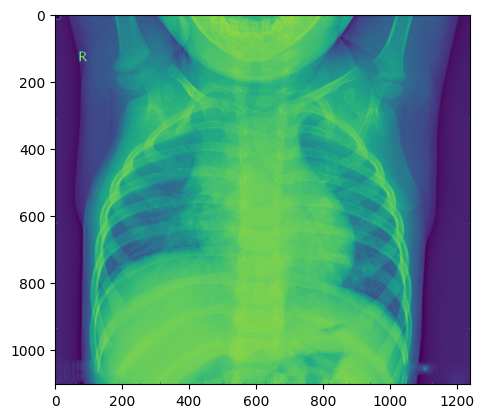

Sample NORMAL2-IM-1436-0001.jpeg


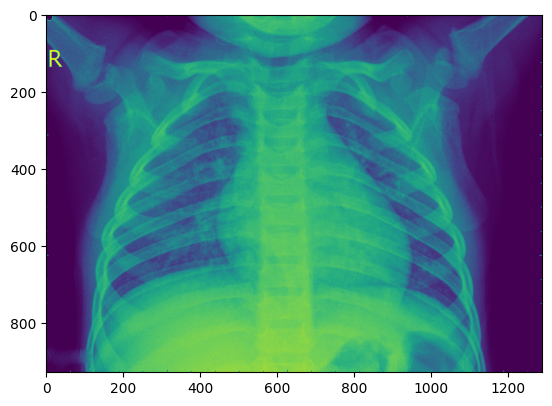

Listing chest_xray.dataset/val/PNEUMONIA
Sample person1952_bacteria_4883.jpeg


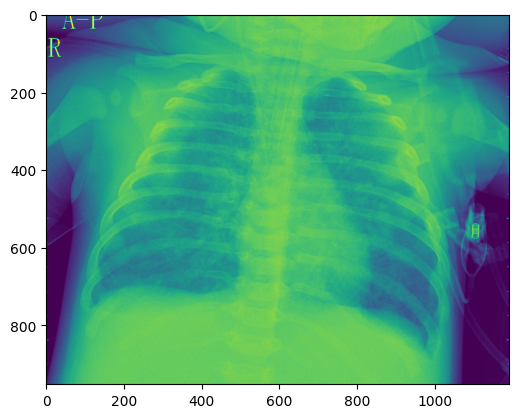

Sample person1949_bacteria_4880.jpeg


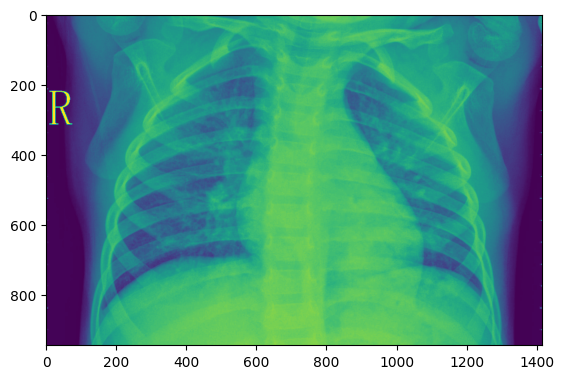

Found 16 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
Processing chest_xray.dataset/train...
Listing chest_xray.dataset/train/NORMAL
Sample NORMAL2-IM-0809-0001.jpeg


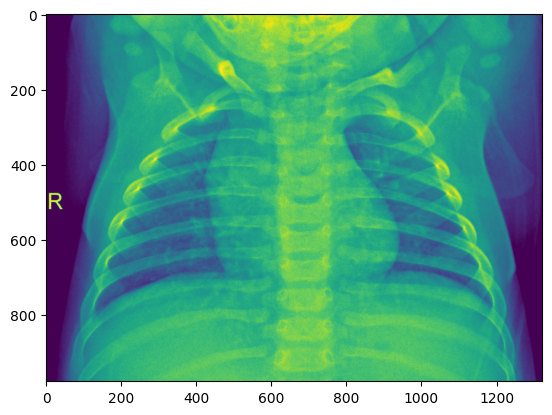

Sample IM-0303-0001.jpeg


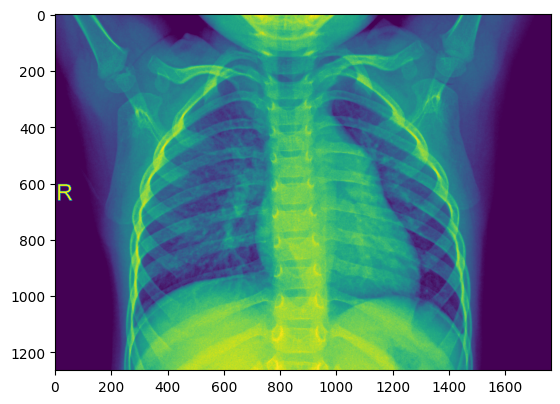

Listing chest_xray.dataset/train/PNEUMONIA
Sample person1599_bacteria_4201.jpeg


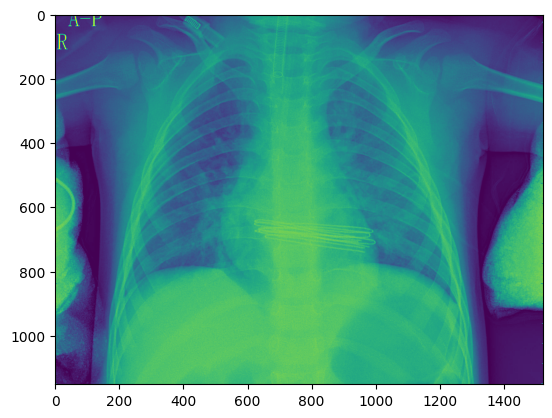

Sample person23_bacteria_102.jpeg


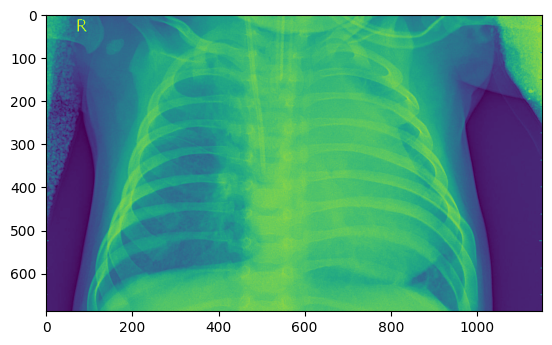

Found 5216 images belonging to 2 classes.
2/2 [==============================] - 8s 3s/step
Processing chest_xray.dataset/test...
Listing chest_xray.dataset/test/NORMAL
Sample NORMAL2-IM-0287-0001.jpeg


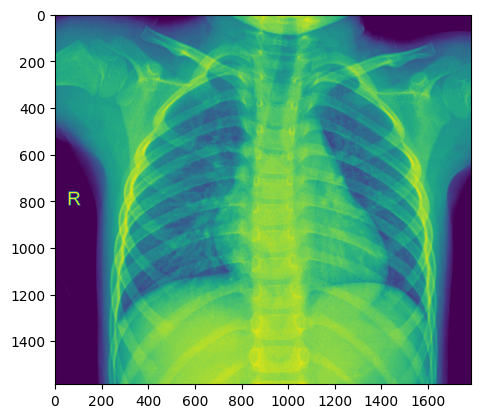

Sample NORMAL2-IM-0339-0001.jpeg


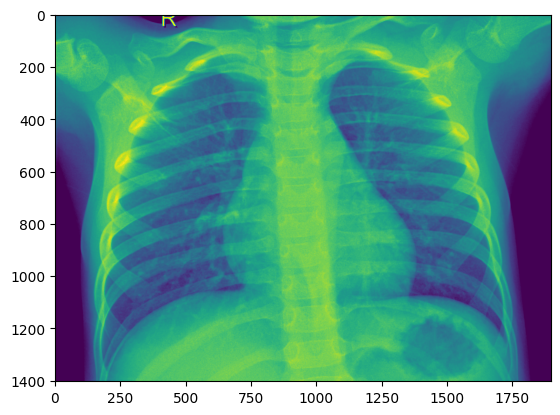

Listing chest_xray.dataset/test/PNEUMONIA
Sample person1612_virus_2798.jpeg


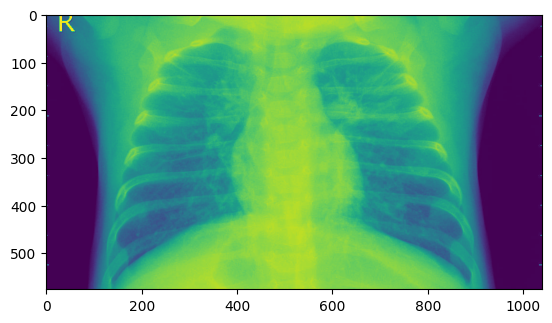

Sample person1662_virus_2875.jpeg


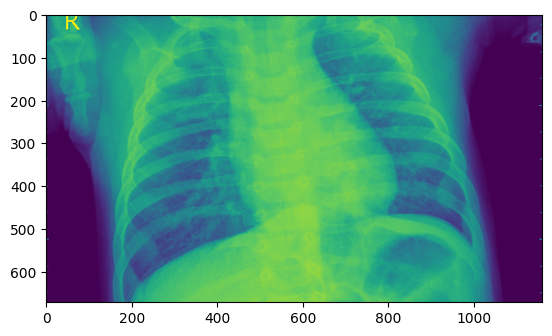

Found 624 images belonging to 2 classes.
1/1 [==============================] - 4s 4s/step
Complete


In [7]:
import os, matplotlib, numpy
import matplotlib.image, matplotlib.pyplot

# Specify dataset size
batch_size = 50

# Specify reference for directory paths
dataset_root = "chest_xray.dataset"
classifications = [ "NORMAL", "PNEUMONIA" ]
folders = [ "val", "train", "test" ]

def show_image(filename):
    img = matplotlib.image.imread(filename)
    matplotlib.pyplot.imshow(img)
    matplotlib.pyplot.show()    

#def preprocess_data(examples):
def dataset_size(directory, labels, showSample=False):
    size = 0 
    for label in labels:
        path = "{}/{}".format(directory, label)
        print("Listing {}".format(path))
        contents = os.listdir(path)
        size += len(contents)
        if showSample:
            for pic_file in  numpy.random.choice(contents, 2):
                print("Sample {}".format(pic_file))
                show_image("{}/{}".format(path,pic_file))
    return size    

def extract_features(directory, sample_amount):
    features = numpy.zeros(shape=(sample_amount, 7, 7, 512)) 
    labels = numpy.zeros(shape=(sample_amount))
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255) 
    generator = datagen.flow_from_directory(
        directory, target_size=(228, 228), 
        batch_size = batch_size, 
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

# Apply extraction function to 3 datasets
dataset = {}
dataset['features'] = {}
dataset['labels'] = {}

for folder in folders:
    path = "{}/{}".format(dataset_root, folder)
    print("Processing {}...".format(path))
    num_samples = dataset_size(path, classifications, True)
    features, labels = extract_features(path, min(1000, num_samples))
    dataset['features'][folder] = features
    dataset['labels'][folder] = labels

print("Complete")


In [8]:
# Shape data
reshape_y = 7 * 7 * 512
for folder in folders:
    print("Reprocessing {}...".format(folder))
    dataset['features'][folder] = numpy.reshape(dataset['features'][folder], (len(dataset['features'][folder]), reshape_y))

print("Complete")

Reprocessing val...
Reprocessing train...
Reprocessing test...
Complete


In [14]:
# Define size
batch_size = 16 # Batch size defines the number of samples that will be propagated through the network
target_size = (228, 228) # use the same pixel h * w target size for all images processed

# Configure augmentation for training adversity
# ImageDataGenerator rescales the pixels between zero and one
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# Set augmentation for testing
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


generators = {}
for folder in ['train', 'val']:
    # Read pictures in 'data/train' directory and generate batches of image data with binary labels
    path = "{}/{}".format(dataset_root, folder)
    print("Processing {}...".format(path))
    generator = train_datagen.flow_from_directory(
        path,  
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')
    generators[folder] = generator

print("Complete")

Processing chest_xray.dataset/train...
Found 5216 images belonging to 2 classes.
Processing chest_xray.dataset/val...
Found 16 images belonging to 2 classes.
Complete


In [23]:
# Set stop to 5 epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    restore_best_weights=True,
    patience=5
)

# Warning: the step below takes ~40min.

# Save weights after implemeting callback to later compare
history = altmodel.fit(
        generators['train'],
        steps_per_epoch=2084 // batch_size, # 2084 is train generator result
        epochs=30, # num of epochs will dictate speed of model 
        validation_data=generators['val'],
        validation_steps=167 // batch_size, # 167 is validation generator result
        callbacks=[callback]
)
# Create directory to save results
#os.mkdir('models')
altmodel.save('models/model_01.keras')

Epoch 1/30
130/130 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9288WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 10 batches). You may need to use the repeat() function when building your dataset.


130/130 [==============================] - 64s 493ms/step - loss: 0.2152 - accuracy: 0.9288 - val_loss: 1.6709 - val_accuracy: 0.6250
Epoch 2/30
130/130 [==============================] - 63s 483ms/step - loss: 0.1972 - accuracy: 0.9317
Epoch 3/30
130/130 [==============================] - 63s 485ms/step - loss: 0.1876 - accuracy: 0.9322
Epoch 4/30
130/130 [==============================] - 63s 488ms/step - loss: 0.1898 - accuracy: 0.9293
Epoch 5/30
130/130 [==============================] - 64s 493ms/step - loss: 0.1879 - accuracy: 0.9337
Epoch 6/30
130/130 [==============================] - 64s 490ms/step - loss: 0.1823 - accuracy: 0.9375
Epoch 7/30
130/130 [==============================] - 64s 492ms/step - loss: 0.1943 - accuracy: 0.9298
Epoch 8/30
130/130 [==============================] - 64s 492ms/step - loss: 0.1923 - accuracy: 0.9303
Epoch 9/30
130/130 [==============================] - 63s 483ms/step - loss: 0.1976 - accuracy: 0.9322
Epoch 10/30
130/130 [=====================

Found 16 images belonging to 2 classes.
1/1 [==============================] - 0s 24ms/step
tree


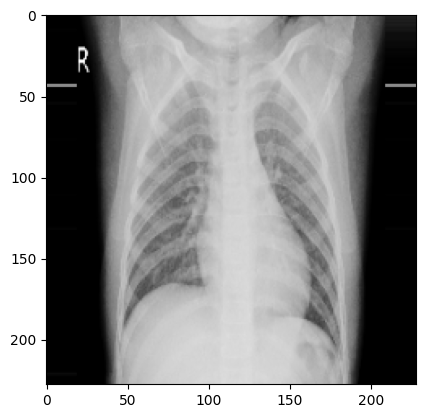


1/1 [==============================] - 0s 22ms/step
tree


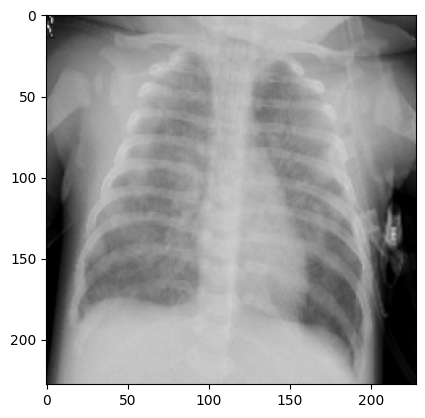


1/1 [==============================] - 0s 22ms/step
tree


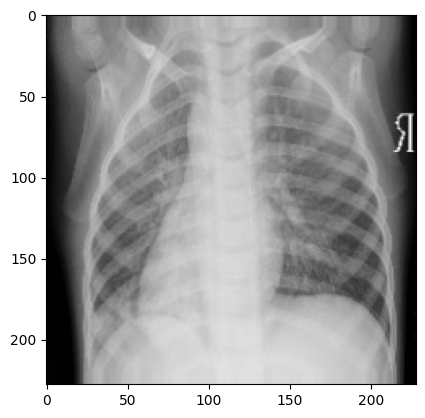


1/1 [==============================] - 0s 22ms/step
tree


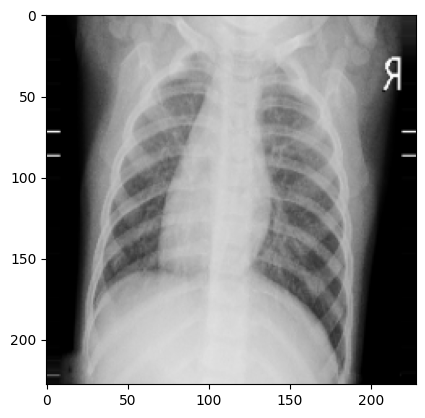


1/1 [==============================] - 0s 22ms/step
not_tree


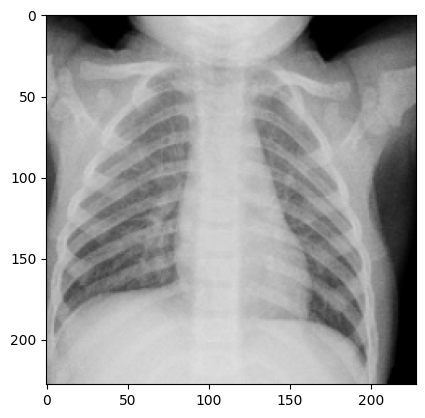

In [33]:

# Validation generator with batch size = 1 

#generators['val'].batch_size = 1

path = "{}/{}/PNEUMONIA".format(dataset_root, folder)
path = "{}/{}".format(dataset_root, folder)
generator = train_datagen.flow_from_directory(
    path,  
    target_size=target_size,
    batch_size=1,
    class_mode='binary')

# Preview examples from validation set and labels predicted from baseline model
for _ in range(5):
    x = next(generators['val'])[0]
    #print(x)
    print('tree' if altmodel.predict(x)[0][0] > 0.5 else 'not_tree')
    matplotlib.pyplot.imshow(x.reshape((228, 228, 3)))
    matplotlib.pyplot.show()
    print()
    

In [38]:
import pandas

print(history)
print(history.params)
print(history.history.keys())
print(history.history.values())

# Plot model training performance
pandas.DataFrame(history.history.values()).plot(figsize=(5, 5))
matplotlib.pyplot.title('Baseline Performance')
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Metric')
matplotlib.pyplot.show()

{'verbose': 1, 'epochs': 30, 'steps': 130}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_values([[0.21518072485923767, 0.19715642929077148, 0.18762223422527313, 0.18977168202400208, 0.18786360323429108, 0.18232744932174683, 0.1942819505929947, 0.19232551753520966, 0.19756077229976654, 0.18184898793697357, 0.17730912566184998, 0.17147371172904968, 0.1713314950466156, 0.1722792088985443, 0.17249058187007904, 0.15603703260421753, 0.16098855435848236, 0.1796131730079651, 0.17023731768131256], [0.9288461804389954, 0.9317307472229004, 0.9322115182876587, 0.9293269515037537, 0.9336538314819336, 0.9375, 0.9298076629638672, 0.9302884340286255, 0.9322115182876587, 0.9399038553237915, 0.9389423131942749, 0.9399038553237915, 0.9350961446762085, 0.9461538195610046, 0.9413461685180664, 0.9442307949066162, 0.9442307949066162, 0.9355769157409668, 0.9389423131942749], [1.6709436178207397], [0.625]])


ValueError: All arrays must be of the same length

In [17]:
# Build classifier on top of  VGG19
model = tf.keras.models.Sequential()

# Add dense layers on top of VGG19 
# 1
model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=reshape_y))
# 2
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(dataset['features']['train'], dataset['labels']['train'],
                    epochs=20,
                    batch_size=16,
                    validation_data=(dataset['features']['val'], dataset['labels']['val']))

# Save VGG19 results
model.save('models/model_VGG_01.keras')

Epoch 1/20
63/63 [==============================] - 2s 25ms/step - loss: 0.3648 - acc: 0.8510 - val_loss: 0.4146 - val_acc: 0.8125
Epoch 2/20
63/63 [==============================] - 1s 22ms/step - loss: 0.1421 - acc: 0.9530 - val_loss: 1.3476 - val_acc: 0.5625
Epoch 3/20
63/63 [==============================] - 1s 23ms/step - loss: 0.1277 - acc: 0.9430 - val_loss: 1.2150 - val_acc: 0.5625
Epoch 4/20
63/63 [==============================] - 2s 24ms/step - loss: 0.1038 - acc: 0.9510 - val_loss: 1.7802 - val_acc: 0.5625
Epoch 5/20
63/63 [==============================] - 2s 24ms/step - loss: 0.0816 - acc: 0.9690 - val_loss: 0.2192 - val_acc: 0.9375
Epoch 6/20
63/63 [==============================] - 2s 25ms/step - loss: 0.0646 - acc: 0.9750 - val_loss: 0.3753 - val_acc: 0.7500
Epoch 7/20
63/63 [==============================] - 2s 24ms/step - loss: 0.0589 - acc: 0.9790 - val_loss: 0.2381 - val_acc: 0.9375
Epoch 8/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0482 - a